# DF PREPARATION
**GOAL.** Prepare dataframes as given in the `data` folder. In particular, we will focus on:
- Prepare the dataset for decision trees and logistic regression
- Handle missing values, as detailed in the Excel Sheet
- Export the treated datasets in `our data` folder
- Eventually transform all of this procedure in a single module, to generalize on any type of data

## Loading data

In [3]:
import pandas as pd
import sklearn as sk

print("pandas",pd.__version__)
print("sklearn",sk.__version__)

df = pd.read_csv("../data/obesity_train.csv")
df.head()

pandas 2.2.2
sklearn 1.4.2


,id,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,marrital_status,meals_perday,...,parent_overweight,physical_activity_perweek,region,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level
0,1,21.0,Never,no,up to 5,Sometimes,Female,1.62,NaN,3.0,...,yes,NaN,LatAm,3.0,no,Public,Sometimes,1 to 2,64.0,Normal_Weight
1,2,23.0,Frequently,no,up to 5,Sometimes,Male,1.80,NaN,3.0,...,yes,3 to 4,LatAm,0.0,no,Public,Sometimes,1 to 2,77.0,Normal_Weight
2,3,NaN,Frequently,no,up to 2,Sometimes,Male,1.80,NaN,3.0,...,no,3 to 4,LatAm,2.0,no,Walk,Always,1 to 2,87.0,Overweight_Level_I
3,4,22.0,Sometimes,no,up to 2,Sometimes,Male,1.78,NaN,1.0,...,no,NaN,LatAm,3.0,no,Public,Sometimes,1 to 2,90.0,Overweight_Level_II
4,5,22.0,Sometimes,no,up to 2,Sometimes,Male,1.64,NaN,3.0,...,no,5 or more,LatAm,3.0,no,Public,Sometimes,1 to 2,53.0,Normal_Weight


## Removing Columns
First we will remove the columns which we agreed on dropping.

In [4]:
df = df.drop(columns=["marrital_status", "region"])
df.columns

Index(['id', 'age', 'alcohol_freq', 'caloric_freq', 'devices_perday',
       'eat_between_meals', 'gender', 'height', 'meals_perday',
       'monitor_calories', 'parent_overweight', 'physical_activity_perweek',
       'siblings', 'smoke', 'transportation', 'veggies_freq', 'water_daily',
       'weight', 'obese_level'],
      dtype='object')

## Removing Outliers
Before treating missing data, we will remove outliers to avoid biased results. In particular, we will treat multidimensional outliers in `weight` $\times$ `height`. To detect them, we will be manually visualizing the scatterplot to detect any potential outliers.

In [144]:
# Define a list of IDs containing the IDs of outliers
outliers = []

# New dataframe with just weight x height
weight_height = df.loc[: ,["weight", "height"]]
weight_height.head()

# Remove missing values
weight_height = weight_height.dropna()

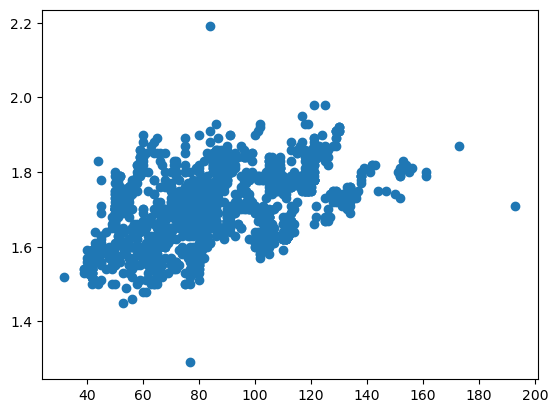

In [145]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(weight_height["weight"], weight_height["height"])

We see four potential outliers: one that is around $(77, 1.3)$, another $(80, 2.2)$, $(190,1.7)$ and $(175, 1.9)$. We will search them manually using the `.query()` method.

In [146]:
query = "(weight>65 & height < 1.4) | (weight >70 & height > 2.1) | (weight > 165)"

outliers.append(weight_height.query(query).index.tolist())

In [147]:
outliers

[[115, 259, 344, 1135]]

Now we have our first set of outliers detected by weight and height. Now we do the same for age and height.

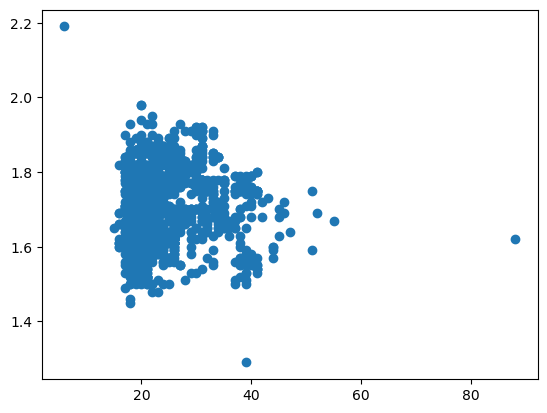

In [148]:
age_height = df.loc[: ,["age", "height"]]
age_height = age_height.dropna()

fig, ax = plt.subplots()
ax.scatter(age_height["age"], age_height["height"])

$$
(<10, \sim2.2),(\sim 40, <1.4),(>80, \sim 1.6),
$$

In [149]:
outliers.append(age_height.query("(age < 10 & height>2) | (age>35 & height < 1.4) | (age > 80 & height > 1.5)").index.tolist())

In [150]:
outliers

[[115, 259, 344, 1135], [115, 1013, 1135]]

Repeat for age and weight


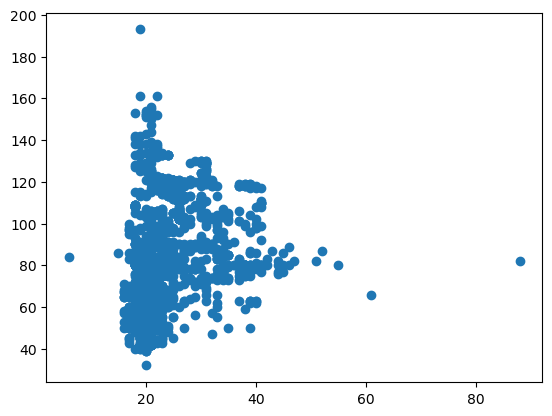

In [152]:
age_weight = df.loc[: ,["age", "weight"]]
age_weight = age_weight.dropna()

fig, ax = plt.subplots()
ax.scatter(age_weight["age"], age_weight["weight"])


$$
(<10, \sim 80), \forall(>45, x), (\sim 20, >180)
$$

In [156]:
outliers.append(age_weight.query("(age<10 & weight>80) | (age>50) | (weight>180)").index.tolist())

In [157]:
outliers

[[115, 259, 344, 1135], [115, 1013, 1135], [12, 100, 115, 344, 782, 882, 1013]]

Finally, having every outlier properly (well, kind of...) identified, we will move onto deletion. First of all we will take the union of every sublist, and turn it into a set.

In [163]:
l = []
for x in outliers:
    for out in x:
        if out in l:
            continue
        else:
            l.append(out)

In [164]:
l

[115, 259, 344, 1135, 1013, 12, 100, 782, 882]

In [167]:
# Proceed to remove outliers from dataset
df = df.drop(l, axis=0)

In [168]:
df

,id,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,parent_overweight,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level
0,1,21.0,Never,no,up to 5,Sometimes,Female,1.62,3.0,no,yes,NaN,3.0,no,Public,Sometimes,1 to 2,64.0,Normal_Weight
1,2,23.0,Frequently,no,up to 5,Sometimes,Male,1.80,3.0,no,yes,3 to 4,0.0,no,Public,Sometimes,1 to 2,77.0,Normal_Weight
2,3,NaN,Frequently,no,up to 2,Sometimes,Male,1.80,3.0,no,no,3 to 4,2.0,no,Walk,Always,1 to 2,87.0,Overweight_Level_I
3,4,22.0,Sometimes,no,up to 2,Sometimes,Male,1.78,1.0,no,no,NaN,3.0,no,Public,Sometimes,1 to 2,90.0,Overweight_Level_II
4,5,22.0,Sometimes,no,up to 2,Sometimes,Male,1.64,3.0,no,no,5 or more,3.0,no,Public,Sometimes,1 to 2,53.0,Normal_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1607,21.0,Sometimes,NaN,up to 5,Sometimes,Female,1.73,3.0,no,yes,3 to 4,1.0,no,Public,Always,1 to 2,131.0,Obesity_Type_III
1607,1608,22.0,Sometimes,yes,up to 5,Sometimes,Female,1.75,3.0,no,yes,1 to 2,0.0,no,NaN,Always,1 to 2,134.0,Obesity_Type_III
1608,1609,23.0,Sometimes,yes,up to 5,Sometimes,Female,1.75,3.0,no,yes,1 to 2,0.0,no,Public,Always,1 to 2,134.0,Obesity_Type_III
1609,1610,24.0,Sometimes,yes,up to 5,Sometimes,Female,1.74,3.0,no,yes,1 to 2,0.0,no,Public,Always,more than 2,133.0,Obesity_Type_III


### Possible alternative: Using three-dimensional Kmeans
To detect outliers we could have used 3D Kmeans, by age x weight x height. However, this could yield strange results as data does not seem to follow a normal distribution.

In [170]:
from sklearn.cluster import KMeans

In [187]:
thriple = df.loc[:, ["age", "weight", "height"]]
thriple = thriple.dropna()

result = KMeans(8).fit_predict(thriple)
result

thriple["g"] = result
thriple.groupby("g").count().sort_values(by="age")

,age,weight,height
g,,,
7,63,63,63
5,104,104,104
6,129,129,129
4,182,182,182
0,219,219,219
3,233,233,233
1,238,238,238
2,307,307,307


## Scaling Data
Before doing using any data mining techniques to fill empty data, we have to perform data scaling on *continuous* variables. Although data is void of multidimensional outliers, we could still have unidimensional outliers. Therefore, before selecting a scaling method, we will analyze each *numerical data* first.

In [199]:
# Age
df['age'].dropna().describe()

count    1537.000000
mean       24.230319
std         6.054896
min        15.000000
25%        20.000000
50%        23.000000
75%        26.000000
max        51.000000
Name: age, dtype: float64

For `age` we have $\mu = 24 \approx Q_{.5} = 23$, thefore we can conclude that our data does not have significant outliers.

In [200]:
# Weight
df['weight'].dropna().describe()

count    1549.000000
mean       86.865074
std        25.908440
min        32.000000
25%        67.000000
50%        83.000000
75%       107.000000
max       161.000000
Name: weight, dtype: float64

For `weight` we have $\mu = 86.87 \approx 83.00 = Q_{.5}$. Accompanied by the fact that we have a high standard deviation, this indicates a potential presence of *outliers*. To investigate, we're going to plot the graph of weights.

(array([ 53., 180., 235., 317., 191., 211., 239.,  91.,  17.,  15.]),
 array([ 32. ,  44.9,  57.8,  70.7,  83.6,  96.5, 109.4, 122.3, 135.2,
        148.1, 161. ]),
 <BarContainer object of 10 artists>)

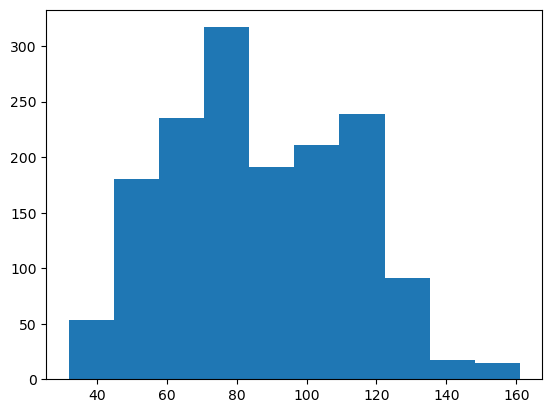

In [207]:
plt.hist(df['weight'])

Clearly there are outliers for $\text{weight}>135.2$. In conclusion, a different scaling method will be used for this.

In [208]:
# Height
df['height'].dropna().describe()

count    1589.000000
mean        1.704009
std         0.094332
min         1.450000
25%         1.630000
50%         1.700000
75%         1.770000
max         1.980000
Name: height, dtype: float64

As $\mu \approx Q_{.5}$ and our standard error is low, we can safely infer that `height` does not contain outliers.

Now finally we're going to scale our data. In particular,
- `StandardScaler` will be applied to `age`, `height`
- `RobustScaler` will be applied to `weight`

In [226]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scale_age = StandardScaler().fit(df[["age"]].dropna())
scale_height = StandardScaler().fit(df[["height"]].dropna())
scale_weight = RobustScaler().fit(df[["weight"]].dropna())

new_age = scale_age.transform(df[["age"]])
new_height = scale_height.transform(df[["height"]])
new_weight = scale_weight.transform(df[["weight"]])

In [227]:
# Replace columns
df["age"] = new_age
df["height"] = new_height
df["weight"] = new_weight

In [229]:
df.head(5)

,id,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,parent_overweight,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level
0,1,-0.533679,Never,no,up to 5,Sometimes,Female,-0.890849,3.0,no,yes,NaN,3.0,no,Public,Sometimes,1 to 2,-0.475,Normal_Weight
1,2,-0.203260,Frequently,no,up to 5,Sometimes,Male,1.017913,3.0,no,yes,3 to 4,0.0,no,Public,Sometimes,1 to 2,-0.150,Normal_Weight
2,3,NaN,Frequently,no,up to 2,Sometimes,Male,1.017913,3.0,no,no,3 to 4,2.0,no,Walk,Always,1 to 2,0.100,Overweight_Level_I
3,4,-0.368470,Sometimes,no,up to 2,Sometimes,Male,0.805828,1.0,no,no,NaN,3.0,no,Public,Sometimes,1 to 2,0.175,Overweight_Level_II
4,5,-0.368470,Sometimes,no,up to 2,Sometimes,Male,-0.678764,3.0,no,no,5 or more,3.0,no,Public,Sometimes,1 to 2,-0.750,Normal_Weight



## Replacing Categorical Variables
As we have a lot of categorical variables, we want to replace them with numbers (dummy variables). More details in the Excel Sheet.

In [247]:
# General line: df["..."] = df["..."].astype("category").cat.codes
to_transform = df.select_dtypes("object").columns.tolist()
for transformer in to_transform:
    df[f"{transformer}"] = df[f"{transformer}"].astype("category").cat.codes

In [249]:
df.head(5)

,id,age,alcohol_freq,caloric_freq,devices_perday,eat_between_meals,gender,height,meals_perday,monitor_calories,parent_overweight,physical_activity_perweek,siblings,smoke,transportation,veggies_freq,water_daily,weight,obese_level
0,1,-0.533679,2,0,2,3,0,-0.890849,3.0,0,1,-1,3.0,0,3,2,0,-0.475,1
1,2,-0.203260,1,0,2,3,1,1.017913,3.0,0,1,1,0.0,0,3,2,0,-0.150,1
2,3,NaN,1,0,1,3,1,1.017913,3.0,0,0,1,2.0,0,4,0,0,0.100,5
3,4,-0.368470,3,0,1,3,1,0.805828,1.0,0,0,-1,3.0,0,3,2,0,0.175,6
4,5,-0.368470,3,0,1,3,1,-0.678764,3.0,0,0,2,3.0,0,3,2,0,-0.750,1


# WARNING! Missing data is -1, for some reason...
Not a problem but we will have to keep this in mind when handling missing vals

## Handle Missing Values
Now we have to handle missing values. In particular, we will:
- Replace missing values for `physical_activity_perweek` with $0$, as the missing values could represent for *no physical activity* being done at all. The fact that this column has $35\%$ missing motivates this choice.
- Replace `transportation` with its mode, as investigations reveal that this variable is not much significant anyways.
- Remove rows with missing values for siblings or smoke (further analysis reveals that only 24 rows have either of them missing)


In [195]:
df.isna().query("siblings | smoke").shape

(24, 19)

24 Rows of missing values for siblings or smoke. 0 with both of them missing.

In [250]:
# TODO